In [39]:
import pandas as pd
import numpy as np
import pickle
import re
from tqdm import tqdm
import seaborn as sns
#from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, f1_score
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator

In [70]:
sns.set_theme()
sns.set_context("talk", font_scale=1.7)#, rc={"font.size": 7})
sns.set_style(style={'xtick.bottom': True,'ytick.left': True, 'axes.edgecolor': 'black'})

In [2]:
data_dir = '/s/project/mll/sergey/effect_prediction/MLM/motif_predictions/split_75_25/'

In [23]:
test_df = pd.read_csv(data_dir + 'test.csv').set_index('seq_name').squeeze()

In [203]:
table_motifs = pd.read_csv(data_dir + '../motifs.csv')

In [263]:
models = {'Dinucl.':'dinucl','11-mer':'11_mer','Species-agnostic':'../species_agnostic/motif_probas',
          'Species-aware':'../species_aware/motif_probas'}

In [264]:
res = {}

for model, model_path in models.items():
    with open(data_dir + model_path + '.pickle','rb') as f:
        res[model] = dict(pickle.load(f))

In [265]:
selected_proteins = ['HNRNPL', 'TIA1', 'KHDRBS2', 'PCBP2', 'TRA2A', 'FUS', 'PUM1']

In [266]:
table_motifs.loc[table_motifs.protein.isna(), 'protein'] = 'Random' 
selected_motifs = table_motifs[table_motifs.protein.isin(selected_proteins)].drop_duplicates(subset='protein',keep='first')
selected_motifs = pd.concat([table_motifs[table_motifs.protein=='Random'],selected_motifs]) #add random motifs
selected_motifs = selected_motifs.set_index('protein').squeeze() #convert to series

In [267]:
motifs_df = []

for seq_name,seq in tqdm(test_df.items(), total=len(test_df)):
    for protein, motif in selected_motifs.items():
        label = f'{protein}\n{motif}' if protein!='Random' else 'Random'
        for match in re.finditer(motif,seq):
            for model in models:
                avg_target_prob = np.mean(res[model][seq_name][match.start():match.end()])
                motifs_df.append((model,seq_name,match.start(),label,motif,avg_target_prob))

100%|██████████| 4534/4534 [00:05<00:00, 845.58it/s]


In [268]:
motifs_df = pd.DataFrame(motifs_df,columns = ['model','seq_name','motif_start','label','motif','avg_target_prob'])

/data/ouga/home/ag_gagneur/l_vilov/miniconda3/envs/svilov-python/lib/python3.11/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

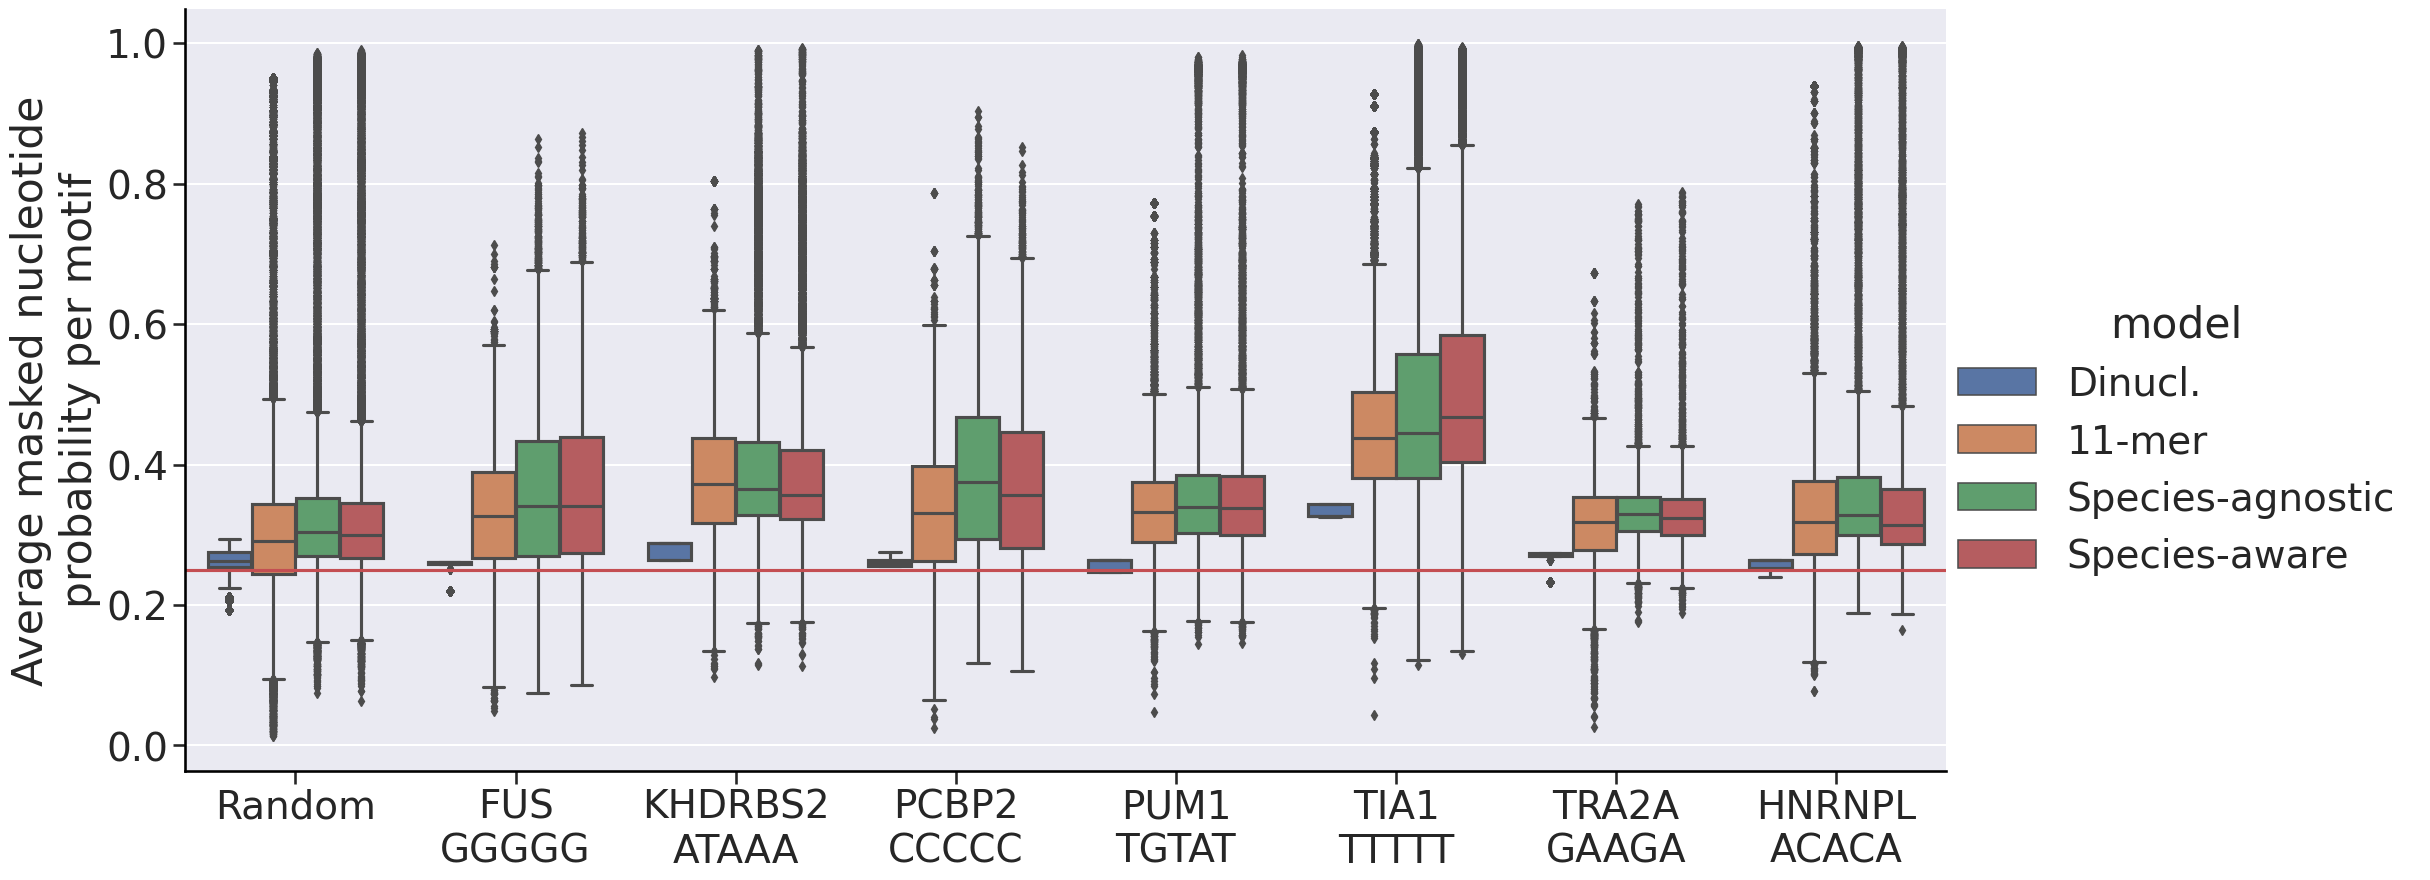

In [269]:
plt.clf()

sns.catplot(data=motifs_df, x="label", y="avg_target_prob", hue="model",
                kind="box", height=10, aspect=2.0, estimator=np.mean)#, palette=custom_colors)

#plt.xticks(rotation = 45, ticks = range(0,8),labels=motifs_df.label.unique())

plt.axhline(0.25,color="r");

plt.xlabel("")
plt.ylabel("Average masked nucleotide\nprobability per motif")
plt.show()